# Ordinary Differential Equations

In [1]:
using DifferentialEquations
include("pubh.jl");

In [2]:
using AlgebraOfGraphics, CairoMakie, MakieThemes
CairoMakie.activate!(type = "svg")
AoG = AlgebraOfGraphics; data = AoG.data
set_theme!(ggthemr(:light))

## Lotka-Volterra

### Model

We start by defining a function, which depends on the vector of variables `u`, parameters `p` and time `t`.

In [3]:
function lotka!(du, u, p, t)
  x, y = u
  α, β, γ, δ = p
  du[1] = dx = α*x  - β*x*y
  du[2] = dy = γ*x*y - δ*y
end

lotka! (generic function with 1 method)

### Parameters

We specify the value of the parameters, the initial conditions and the time span.

In [4]:
lotka_p = (α = 0.1, β = 0.005/60, γ = 4e-5, δ = 0.04)
lotka_u0 = [200, 600]
lotka_tspan = (0.0, 360.0);

### Simulation

In [5]:
lotka_prob = ODEProblem(lotka!, lotka_u0, lotka_tspan, lotka_p)

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 360.0)
u0: 2-element Vector{Int64}:
 200
 600

In [6]:
lotka_sol = solve(lotka_prob, reltol=1e-8, abstol=1e-8);

We find the vector with times in `.t`:

In [7]:
lotka_sol.t[1:5]

5-element Vector{Float64}:
 0.0
 0.0586667239835466
 0.44455978187816814
 1.893063115191294
 4.159798207413832

The matrix for the solutions is in `.u`:

In [8]:
lotka_sol.u[1:5, :]

5×1 Matrix{Vector{Float64}}:
 [200.0, 600.0]
 [200.58808035146404, 598.8750684557691]
 [204.52749633793158, 591.5485461681885]
 [220.4691932972696, 565.1588035709195]
 [249.46510486223053, 527.2643014500746]

### Visualisation

In [9]:
lotka_df = DataFrame(lotka_sol)
rename!(
  lotka_df,
  :value1 => :Prey,
  :value2 => :Predator
)
lotka_melt = stack(lotka_df, Not(:timestamp))
lotka_melt |> head

Row,timestamp,variable,value
,Float64,String,Float64
1,0.0,Prey,200.0
2,0.0586667,Prey,200.588
3,0.44456,Prey,204.527
4,1.89306,Prey,220.469
5,4.1598,Prey,249.465


┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/josie/.julia/packages/Makie/RgxaV/src/makielayout/blocks/legend.jl:23


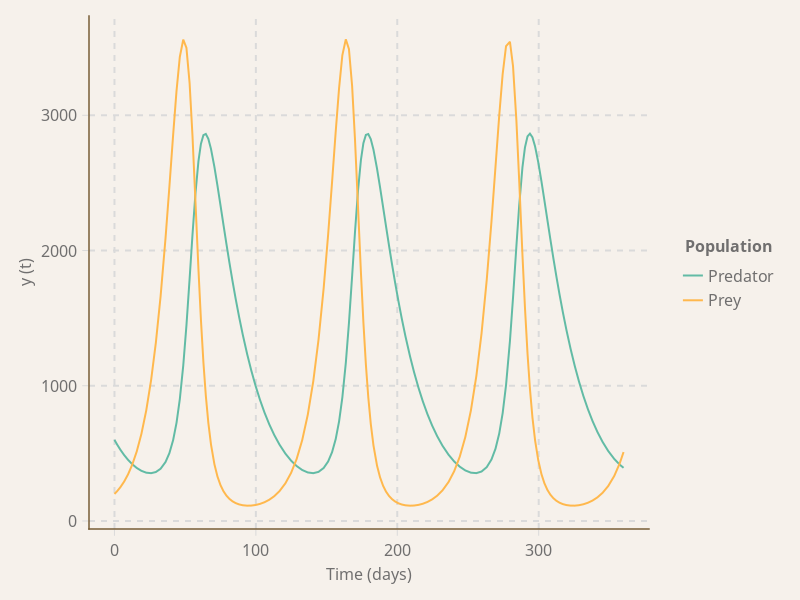

In [10]:
#| label: fig-fig1
#| fig-cap: "Dynamics of Lotka-Volterra model about prey-predator interactions. Example by constructing a data frame."
#| warning: false
data(lotka_melt) *
mapping(
  :timestamp => "Time (days)",
  :value => "y (t)",
  color = :variable => "Population"
) *
visual(Lines) |>
draw

::: callout-note
It is also possible to construct the plot directly from the ODE solution. Defining the data frame, avoids confussion, though.
:::

┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/josie/.julia/packages/Makie/RgxaV/src/makielayout/blocks/legend.jl:23


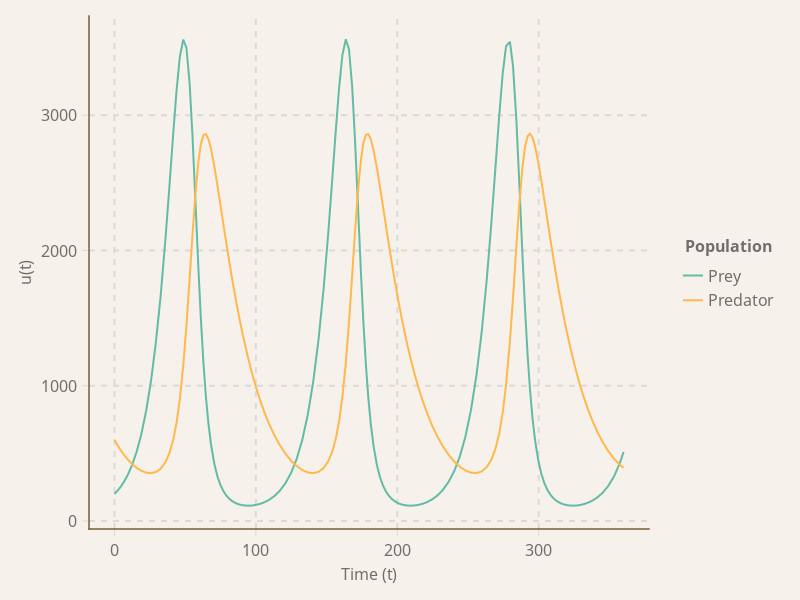

In [11]:
#| label: fig-fig2
#| fig-cap: "Dynamics of Lotka-Volterra model about prey-predator interactions. Plotting directly from the ODE solution."
#| warning: false
let
	labels = ["Prey", "Predator"]
	plt = data(lotka_sol) *
	mapping(
		:timestamp,
		[:value1, :value2],
		color=dims(1) => renamer(labels) => "Population"
	) *
	visual(Lines, linewidth=2)
	draw(plt, 
		axis=(xlabel = "Time (t)", ylabel = "u(t)"))
end

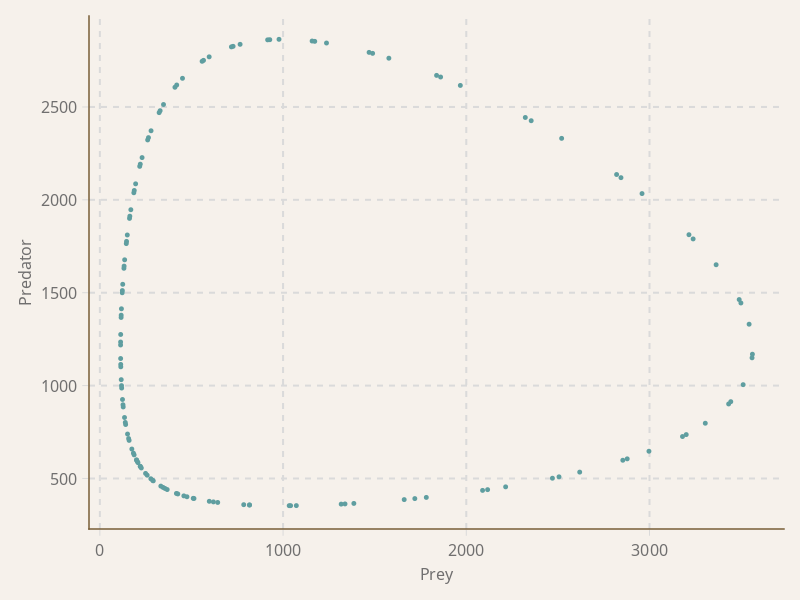

In [12]:
#| label: fig-fig3
#| fig-cap: "Prey-predator model showing cyclic interactions."
data(lotka_df) *
mapping(
  :Prey,
  :Predator
) *
visual(Scatter, color=:cadetblue, markersize=7) |>
draw

## Kermack and McKendrick

### Model

In [13]:
function sir!(du, u, p, t)
  S, I, R = u
  β, γ = p
  du[1] = dS = - β*I*S 
  du[2] = dI = β*I*S - γ*I
  du[3] = dR = γ*I
end

sir! (generic function with 1 method)

### Parameters

In [14]:
sir_p = (β = 0.01, γ = 1/8)
sir_u0 = [200, 1, 0]
sir_tspan = (0.0, 90.0);

### Simulation

In [15]:
sir_prob = ODEProblem(sir!, sir_u0, sir_tspan, sir_p)

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 90.0)
u0: 3-element Vector{Int64}:
 200
   1
   0

In [16]:
sir_sol = solve(sir_prob);

### Visualisation

┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/josie/.julia/packages/Makie/RgxaV/src/makielayout/blocks/legend.jl:23


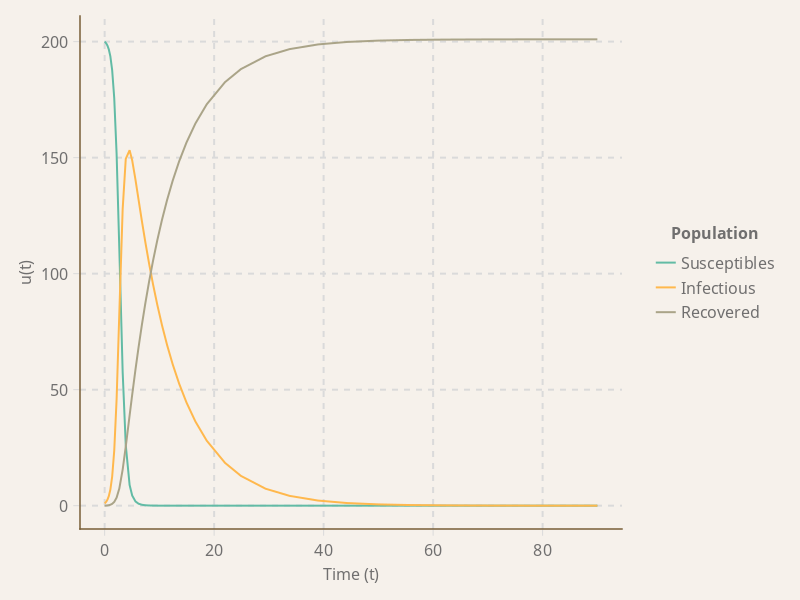

In [17]:
#| label: fig-fig4
#| fig-cap: "Dynamics of SIR model."
#| warning: false
let
	labels = ["Susceptibles", "Infectious", "Recovered"]
	plt = data(sir_sol) *
	mapping(
		:timestamp,
		[:value1, :value2, :value3],
		color=dims(1) => renamer(labels) => "Population"
	) *
	visual(Lines, linewidth=2)
	draw(plt, 
		axis=(xlabel = "Time (t)", ylabel = "u(t)"))
end

## HIV multi-compartmental model

### Model

In [18]:
function sl!(δ, γ, t)
  exp(-δ*t) + (1/γ) * exp(-0.001*t)
end

sl! (generic function with 1 method)

In [19]:
function hiv!(du, u, p, t)
  Vb, Vl, Vf = u
  klb, klf, cl, cb, kfl, δ, γ = p
  du[1] = dVb = klb*Vl - cb*Vb
  du[2] = dVl = sl!(δ, γ, t) - klf*Vl + kfl*Vf - cl*Vl
  du[3] = klf*Vl - kfl*Vf
end

hiv! (generic function with 1 method)

### Parameters

In [20]:
hiv_p = (klb=0.5, klf=0.033, cl=3, cb=4.4, kfl=0.21, δ=0.44, γ=50)
hiv_u0 = [1, 20, 80]
hiv_tspan = (0.0, 2.0);

### Simulation

In [21]:
hiv_prob = ODEProblem(hiv!, hiv_u0, hiv_tspan, hiv_p)

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 2.0)
u0: 3-element Vector{Int64}:
  1
 20
 80

In [22]:
hiv_sol = solve(hiv_prob, reltol=1e-8, abstol=1e-8);

### Visualisation

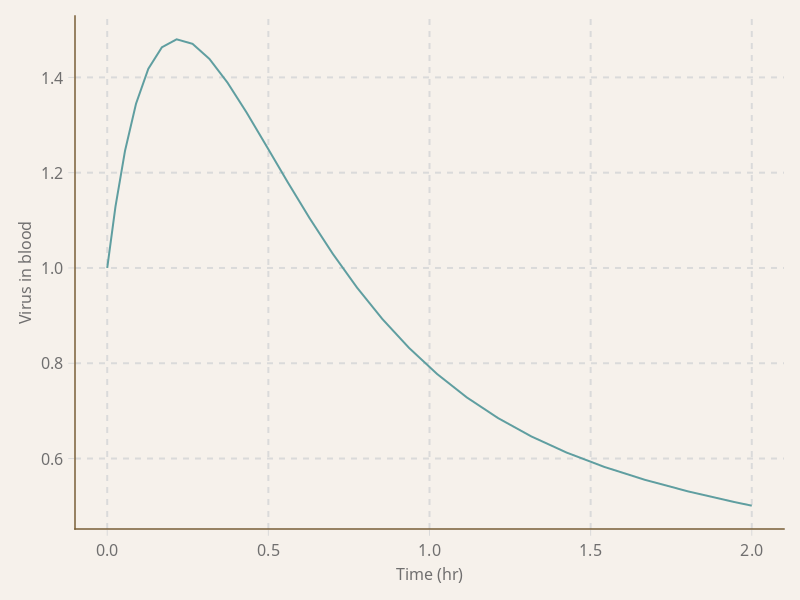

In [23]:
#| label: fig-fig5
#| fig-cap: "Dynamics of viral load in blood after chemotherapy."
data(hiv_sol) *
mapping(
  :timestamp => "Time (hr)",
  :value1 => "Virus in blood"
) *
visual(Lines, color=:cadetblue, linewidth=2) |>
draw

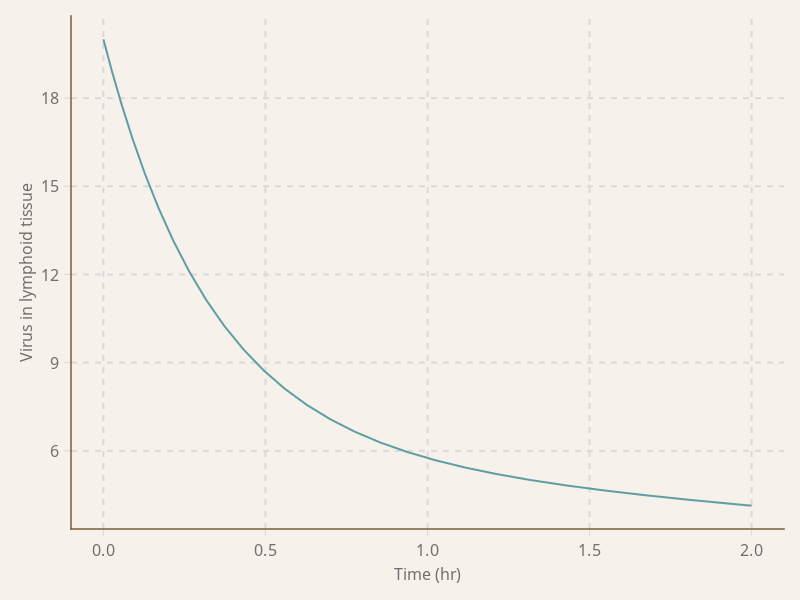

In [24]:
#| label: fig-fig6
#| fig-cap: "Dynamics of viral load in lymphoid tissue after chemotherapy."
data(hiv_sol) *
mapping(
  :timestamp => "Time (hr)",
  :value2 => "Virus in lymphoid tissue"
) *
visual(Lines, color=:cadetblue, linewidth=2) |>
draw

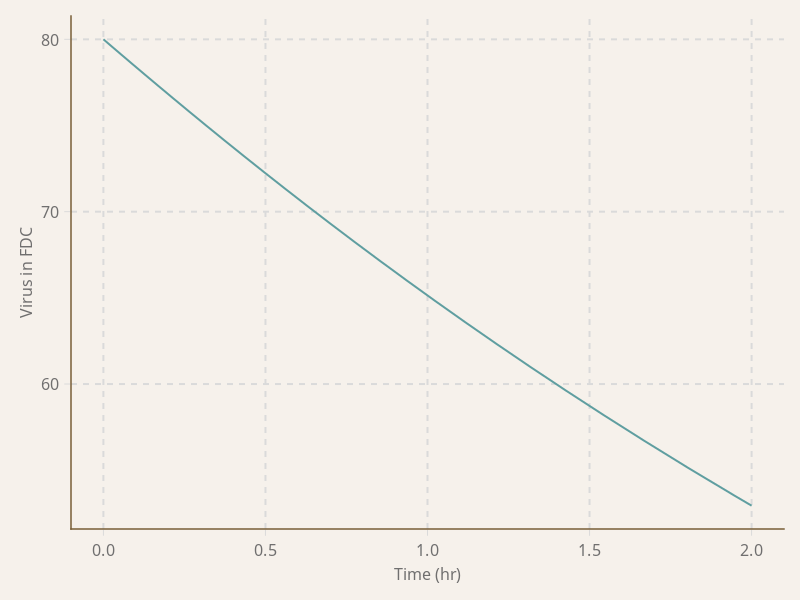

In [25]:
#| label: fig-fig7
#| fig-cap: "Dynamics of viral load in follicular dendritic cells after chemotherapy."
data(hiv_sol) *
mapping(
  :timestamp => "Time (hr)",
  :value3 => "Virus in FDC"
) *
visual(Lines, color=:cadetblue, linewidth=2) |>
draw